In [1]:
import matplotlib.pyplot as plt
import matplotlib
import setup
import numpy as np
from scipy.ndimage import gaussian_filter1d
from dataloaders import DemoDataset
from utils import read_json

In [2]:
# setup dataloader instances
cfg = read_json("config.json")
dataset_cfg = cfg["dataset"]
dataloader_cfg = cfg["dataloader"]
test_cfg = cfg["test"]
# dataset_cfg["params"]["fnames"] = ["recording_0002_2020_12_3.h5"]
dataset_cfg["params"]["fnames"] = ["recording_0003_2020_12_3.h5"]
dataset_cfg["params"]["contact_only"] = False

dataset = DemoDataset(**dataset_cfg["params"])

dataset start time 1.099132776260376, end time 13.03284478187561
there are 1194 samples


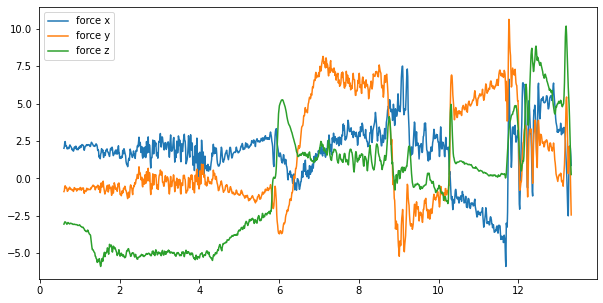

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dataset.all_states_time, dataset.all_states_force[:, 0], label='force x')
ax.plot(dataset.all_states_time, dataset.all_states_force[:, 1], label='force y')
ax.plot(dataset.all_states_time, dataset.all_states_force[:, 2], label='force z')
ax.legend(loc='upper left')
plt.show()

### Reduce force x, y, z to 1d via sumation

In [4]:
sum_xyz = np.sum(dataset.all_states_force, axis=1)
sum_lp = gaussian_filter1d(sum_xyz, sigma=8)

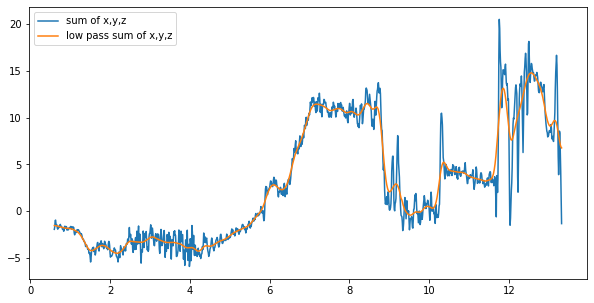

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dataset.all_states_time, sum_xyz, label="sum of x,y,z")
ax.plot(dataset.all_states_time, sum_lp, label="low pass sum of x,y,z")
ax.legend() 
plt.show()

### Energy (square)

- do we need low pass first? for example, apply 1d gaussian to smooth the curves?

In [6]:
# straightforward, compute the energy globally
energy = sum_xyz ** 2
energy_norm = energy / np.amax(energy)  # normalized

# local energy, like low pass
# sum_lp = gaussian_filter1d(sum_xyz, sigma=8)
energy_local = sum_lp ** 2
energy_local_norm = energy_local / np.amax(energy_local)  # normalized

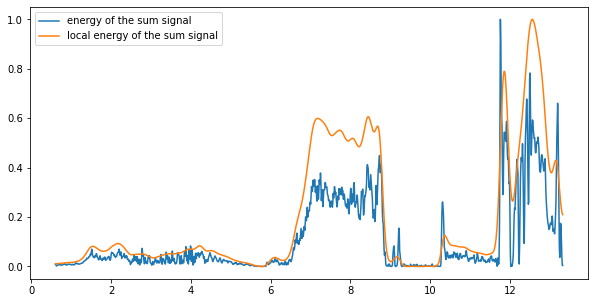

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dataset.all_states_time, energy_norm, label="energy of the sum signal")
ax.plot(dataset.all_states_time, energy_local_norm, label="local energy of the sum signal")
ax.legend()
plt.show()

### Discrete Derivative 

In [8]:
# Differentiation
energy_diff = np.diff(energy_norm)
energy_diff = np.append(energy_diff, 0.0)

energy_local_diff = np.diff(energy_local_norm)
energy_local_diff = np.append(energy_local_diff, 0.0)

# choose local energy diff for novelty here
novelty = np.copy(energy_local_diff)

In [9]:
# normalize to [-1, 1]
novelty /= np.amax(abs(novelty))

In [10]:
# start point should be small, and have large positive novelty
start_mask = (novelty >= .1) & (energy_local_norm <= .2)
start_candidate = np.where(start_mask)[0]

# end point should also be small, and have large negative novelty
end_mask = (novelty <= -.1) & (energy_local_norm <= .25)
end_candidate = np.where(end_mask)[0]

In [11]:
def find_bound(candidate, tolerant=10):
    bound = [candidate[0]]

    for idx in range(candidate.size):
        bound_new = candidate[idx]
        if idx == 0:
            bound_last = bound_new
        
        if bound_new - bound_last >= tolerant:
            bound.append(bound_new)

        bound_last = candidate[idx]
    return np.array(bound)


def match_pair(start, end):
    start_new = []

    for e in end:
        diff = e - start
        min_idx = np.sum(diff > 0) - 1
        start_new.append(start[min_idx])

    return np.array(start_new), end

In [12]:
start = find_bound(start_candidate)
end = find_bound(end_candidate)

start, end = match_pair(start, end)

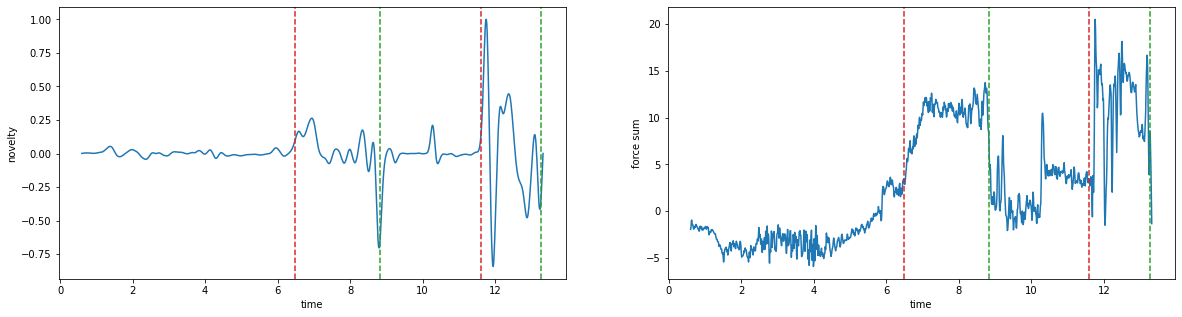

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(dataset.all_states_time, novelty, label="local novelty")
ax1.set_xlabel("time")
ax1.set_ylabel("novelty")
for s in start:
    ax1.axvline(x=dataset.all_states_time[s], color='tab:red', linestyle='--')
for e in end:
    ax1.axvline(x=dataset.all_states_time[e], color='tab:green', linestyle='--')


ax2.plot(dataset.all_states_time, sum_xyz, label="sum xyz")
ax2.set_xlabel("time")
ax2.set_ylabel("force sum")
for s in start:
    ax2.axvline(x=dataset.all_states_time[s], color='tab:red', linestyle='--')
for e in end:
    ax2.axvline(x=dataset.all_states_time[e], color='tab:green', linestyle='--')

ax.legend()
plt.show()